# Shear Horizontal (SH) elastic waves in an unbounded solid

- Time-domain, explicit scheme, Spectral elements
- 2D
- Scalar medium
- Impedance absorbing boundary conditions
- Comparison with an analytical solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dolfinx import mesh, fem, default_scalar_type
import ufl
from mpi4py import MPI
from petsc4py import PETSc

from elastodynamicsx.pde     import material, BodyForce, boundarycondition, PDE, PDECONFIG
from elastodynamicsx.solvers import TimeStepper
from elastodynamicsx.plot    import plotter
from elastodynamicsx.utils   import spectral_element, spectral_quadrature, make_facet_tags, ParallelEvaluator

from analyticalsolutions import u_2D_SH_rt, int_Fraunhofer_2D

### Set up a Spectral Element Method

In [2]:
degElement, nameElement = 4, "GLL"
PDECONFIG.default_metadata = spectral_quadrature(nameElement, degElement)

cell_type = mesh.CellType.quadrilateral
specFE = spectral_element(nameElement, cell_type, degElement)

### FE domain

In [3]:
length, height = 10, 10
Nx, Ny = 100 // degElement, 100 // degElement  # Nb of elts.

# create the mesh
extent = [[0., 0.], [length, height]]
domain = mesh.create_rectangle(MPI.COMM_WORLD, extent, [Nx, Ny], cell_type)

# create the function space
V = fem.FunctionSpace(domain, specFE)

# define some tags
tag_left, tag_top, tag_right, tag_bottom = 1, 2, 3, 4
all_tags = (tag_left, tag_top, tag_right, tag_bottom)
boundaries = [(tag_left  , lambda x: np.isclose(x[0], 0     )),
              (tag_right , lambda x: np.isclose(x[0], length)),
              (tag_bottom, lambda x: np.isclose(x[1], 0     )),
              (tag_top   , lambda x: np.isclose(x[1], height))]

facet_tags = make_facet_tags(domain, boundaries)

### Define the material law

scalar law  
&emsp;-> fluid, or 2D Shear Horizontal polarization

In [4]:
# parameters here...
rho = fem.Constant(domain, default_scalar_type(1))
mu  = fem.Constant(domain, default_scalar_type(1))
# ... end

mat = material(V, 'scalar', rho, mu)

### Boundary conditions
Plane-wave absorbing boundary conditions ('Dashpot')  
&emsp;$\sigma(u).n = Z \partial_t u$ where $Z=\rho c$ is the acoustic impedance of the medium

In [5]:
Z = mat.Z  # mechanical impedance
bc_l = boundarycondition((V, facet_tags, tag_left  ), 'Dashpot', Z)
bc_r = boundarycondition((V, facet_tags, tag_right ), 'Dashpot', Z)
bc_b = boundarycondition((V, facet_tags, tag_bottom), 'Dashpot', Z)
bc_t = boundarycondition((V, facet_tags, tag_top   ), 'Dashpot', Z)

bcs = [bc_l, bc_r, bc_b, bc_t]

### Source term (body force)

In [6]:
# ## -> Space function
X0_src = np.array([length / 2, height / 2, 0])  # Center
R0_src = 0.1  # Radius

# Gaussian function
nrm = 1 / (2 * np.pi * R0_src**2)  # normalize to int[src_x(x) dx]=1


def src_x(x):  # source(x): Gaussian
    r = np.linalg.norm(x - X0_src[:, np.newaxis], axis=0)
    return nrm * np.exp(-1/2 * (r / R0_src)**2, dtype=default_scalar_type)


# ## -> Time function
f0 = 1  # central frequency of the source
T0 = 1 / f0  # period
d0 = 2 * T0  # duration of source


def src_t(t):  # source(t): Sine x Hann window
    window = np.sin(np.pi * t / d0)**2 * (t < d0) * (t > 0)  # Hann window
    return np.sin(2 * np.pi * f0 * t) * window


# ## -> Space-Time function
F_0 = 1  # Amplitude of the source


def F_body_function(t):  # source(x) at a given time
    return lambda x: F_0 * src_t(t) * src_x(x)


# ## Body force 'F_body'
F_body = fem.Function(V)  # body force
gaussianBF = BodyForce(V, F_body)

### Assemble the PDE

In [7]:
pde = PDE(V, materials=[mat], bodyforces=[gaussianBF], bcs=bcs)

### Time scheme

In [8]:
# Temporal parameters
tstart = 0  # Start time
tmax   = 4 * d0  # Final time
num_steps = 500
dt = (tmax - tstart) / num_steps  # time step size

# Some control numbers...
hx = length / Nx
c_SH = np.sqrt(mu.value / rho.value)  # phase velocity
lbda0 = c_SH / f0
courant_number = TimeStepper.Courant_number(V.mesh, ufl.sqrt(mu / rho), dt)

PETSc.Sys.Print(f'Number of points per wavelength at central frequency: {lbda0 / hx:.2f}')
PETSc.Sys.Print(f'Number of time steps per period at central frequency: {T0 / dt:.2f}')
PETSc.Sys.Print(f'CFL condition: Courant number = {courant_number:.2f}')

# Time integration: define a TimeStepper instance
#     diagonal=True assumes the left hand side operator is indeed diagonal
tStepper = TimeStepper.build(V, pde.m, pde.c, pde.k, pde.L, dt, bcs=bcs, scheme='leapfrog', diagonal=True)

# Set the initial values
tStepper.set_initial_condition(u0=0, v0=0, t0=tstart)

Number of points per wavelength at central frequency: 2.50
Number of time steps per period at central frequency: 62.50
CFL condition: Courant number = 0.04


### Define outputs
- Extract signals at few points
- Live-plot results (only in a terminal; not in a notebook)

In [9]:
u_res = tStepper.timescheme.u  # The solution

# -> Store all time steps ? -> YES if debug & learning // NO if big calc.
storeAllSteps = True and domain.comm.size == 1  # WARNING: BUG IN PARALLEL: rank==0 does not return if storeAllSteps==True
all_u = [fem.Function(V) for i in range(num_steps)] if storeAllSteps else None  # all steps are stored here

# -> Extract signals at few points
# Define points
points_out = X0_src[:, np.newaxis] + np.array([[1, 0, 0], [2, 0, 0], [3, 0, 0]]).T

# Declare a convenience ParallelEvaluator
paraEval = ParallelEvaluator(domain, points_out)

# Declare data (local)
signals_local = np.zeros((paraEval.nb_points_local,
                          1,
                          num_steps))  # <- output stored here

# -> Define callbacks: will be called at the end of each iteration
def cbck_storeFullField(i, out):
    if storeAllSteps:
        all_u[i+1].vector.setArray(out)


def cbck_storeAtPoints(i, out):
    if paraEval.nb_points_local > 0:
        signals_local[:, :, i+1] = u_res.eval(paraEval.points_local, paraEval.cells_local)


# -> enable live plotting
clim = 0.1 * F_0 * np.array([-1, 1])
if domain.comm.rank == 0:
    p = plotter(u_res, refresh_step=10, **{'clim': clim})
    if paraEval.nb_points_local > 0:
        # add points to live_plotter
        p.add_points(paraEval.points_local, render_points_as_spheres=True, point_size=12)
    if p.off_screen:
        p.window_size = [640, 480]
        p.open_movie('weq_2D-SH_FullSpace.mp4')
else:
    p = None

### Solve
- Define a 'callfirst' function to update the load
- Run the time loop

In [10]:
# 'callfirsts': will be called at the beginning of each iteration
def cfst_updateSources(t):
    F_body.interpolate(F_body_function(t))


# Run the big time loop!
tStepper.solve(num_steps - 1,
               callfirsts=[cfst_updateSources],
               callbacks=[cbck_storeFullField, cbck_storeAtPoints],
               live_plotter=p)
# End of big calc.

  0%|          | 0/498 [00:00<?, ?it/s]

### Post-processing
- Interactive view of all time steps if stored  
&emsp;-> Plotter with a slider to browse through all time steps
- Plot signals at few points

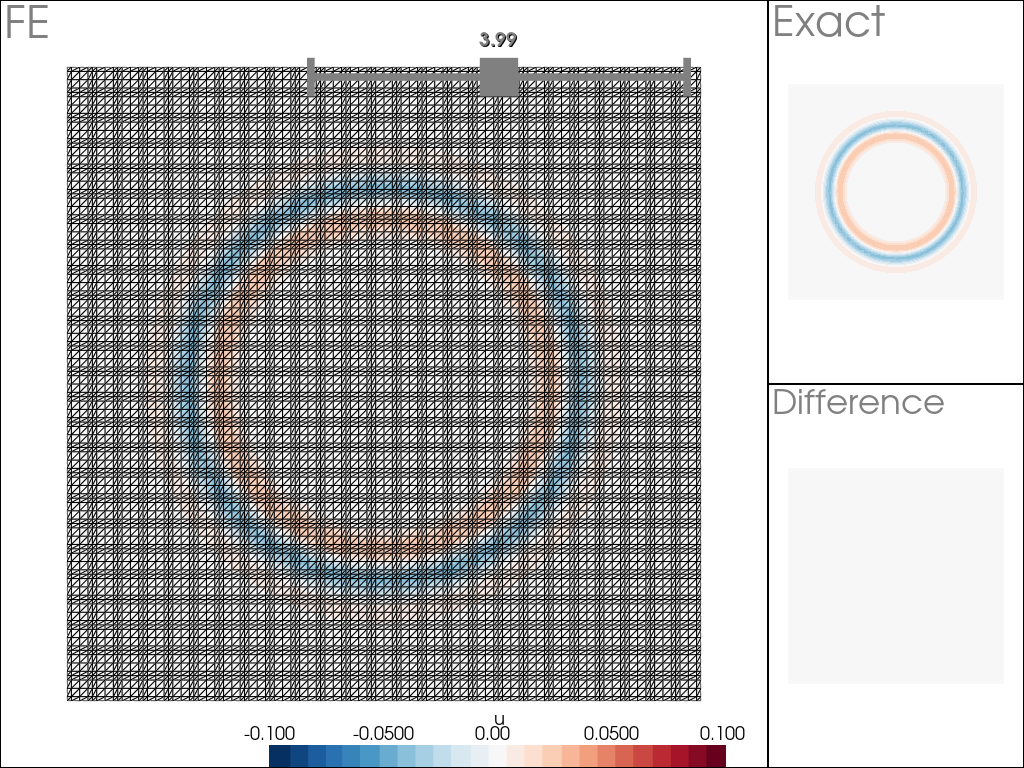

In [11]:
if storeAllSteps and domain.comm.rank == 0:
    # Account for the size of the source in the analytical formula
    fn_kdomain_finite_size = int_Fraunhofer_2D['gaussian'](R0_src)

    # -> Exact solution, Full field
    x = u_res.function_space.tabulate_dof_coordinates()
    r = np.linalg.norm(x - X0_src[np.newaxis, :], axis=1)
    t = dt * np.arange(num_steps)
    all_u_n_exact = u_2D_SH_rt(r, src_t(t), rho.value, mu.value, dt, fn_kdomain_finite_size)

    def update_fields_function(i):
        return (all_u[i].x.array, all_u_n_exact[:, i], all_u[i].x.array - all_u_n_exact[:, i])

    # Initializes with empty fem.Function(V) to have different valid pointers
    p = plotter(fem.Function(V), fem.Function(V), fem.Function(V), labels=('FE', 'Exact', 'Difference'), clim=clim)
    p.add_time_browser(update_fields_function, t)
    p.show()

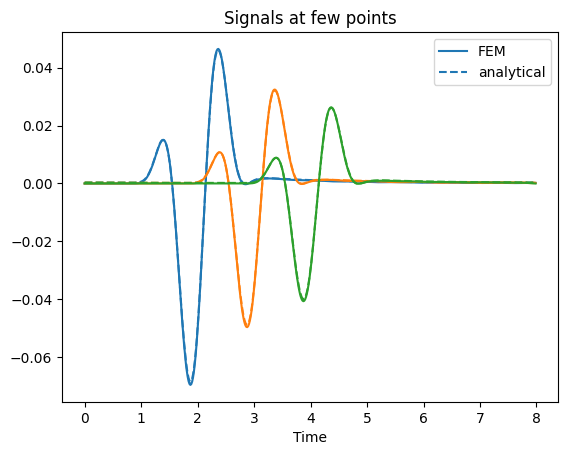

In [12]:
# Gather the data to the root process
all_signals = paraEval.gather(signals_local, root=0)

if domain.comm.rank == 0:
    # Account for the size of the source in the analytical formula
    fn_kdomain_finite_size = int_Fraunhofer_2D['gaussian'](R0_src)

    # -> Exact solution, At few points
    x = points_out.T
    r = np.linalg.norm(x - X0_src[np.newaxis, :], axis=1)
    t = dt * np.arange(num_steps)
    signals_exact = u_2D_SH_rt(r, src_t(t), rho.value, mu.value, dt, fn_kdomain_finite_size)
    #
    fig, ax = plt.subplots(1, 1)
    ax.set_title('Signals at few points')
    for i in range(len(all_signals)):
        ax.plot(t, all_signals[i, 0, :], c=f'C{i}', ls='-')
        ax.plot(t, signals_exact[i, :], c=f'C{i}', ls='--')
    ax.set_xlabel('Time')
    ax.legend(['FEM', 'analytical'])
    plt.show()